In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

生成数据集


In [2]:
def synthetic_data(w, b, num_exemples):
    #生成y=wx+b噪声
    X = torch.normal(0, 1, (num_exemples, len(w)))
    Y = torch.matmul(X, w) + b
    Y += torch.normal(0, 0.01, Y.shape)
    return X, Y.reshape((-1,1))

In [3]:
import torch
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features: ', features[0], '\nlabels: ', labels[0])

features:  tensor([ 0.7888, -1.1415]) 
labels:  tensor([9.6526])


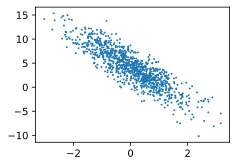

In [5]:
import os 
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(), labels.detach().numpy(), 1);

读取数据集

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    #索引
    indices = list(range(num_examples))
    #样本随机读取
    random.shuffle(indices)
    for i in range(0, num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
    print(X, '\n',y)
    break

tensor([[ 0.0980, -0.7218],
        [ 0.8572,  0.5238],
        [ 1.2856, -0.5122],
        [-0.1214, -1.0506],
        [-1.7398, -2.2362],
        [-0.9697,  0.1029],
        [-0.0376, -1.8558],
        [ 0.7782, -1.4163],
        [-0.4519, -0.0222],
        [-1.3034,  0.3692]]) 
 tensor([[ 6.8462],
        [ 4.1320],
        [ 8.5255],
        [ 7.5438],
        [ 8.3059],
        [ 1.9049],
        [10.4270],
        [10.5708],
        [ 3.3769],
        [ 0.3562]])


初始化模型参数

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad= True)
b = torch.zeros(1, requires_grad= True)

定义模型

In [9]:
def linreg(X, w, b):
    '''线性回归模型'''
    return torch.matmul(X, w)+b

定义损失函数

In [10]:
def squared_loss(y_hat, y):
    '''均方误差'''
    return (y_hat- y.reshape(y_hat.shape))**2/2

定义优化算法

In [11]:
def sgd(params, lr, batch_size):
    '''小批量梯度下降'''
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

训练

In [12]:
#初始化参数
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

#训练过程
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b), y)
        #l的形状是(batch_size, 1)，而不是一个标量
        #l中所有元素被加到一起，并以此计算[w,b]的梯度
        l.sum().backward()
        sgd([w,b], lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss{float(train_l.mean()):f}')

epoch1, loss0.045593
epoch2, loss0.000182
epoch3, loss0.000051


线性回归的简洁实现

In [13]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)



In [14]:
#------------读取数据集--------------#
def Load_array(data_arrays, batch_size, is_train= True):
    '''构建一个数据迭代器'''
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle = is_train)

In [15]:
batch_size = 10
data_iter = Load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-0.0758, -0.7796],
         [ 1.4279, -0.7398],
         [-0.2647,  0.9972],
         [ 0.7964, -0.5345],
         [-1.2534, -1.1955],
         [ 0.7030,  1.0998],
         [ 0.2771,  0.3646],
         [-1.4759, -0.1863],
         [ 1.2402,  0.0608],
         [ 0.7670,  1.6604]]),
 tensor([[6.6865],
         [9.5797],
         [0.2918],
         [7.5978],
         [5.7602],
         [1.8586],
         [3.5083],
         [1.8888],
         [6.4799],
         [0.0863]])]

定义模型

In [16]:
from torch import nn
net = nn.Sequential(nn.Linear(2,1))

初始化参数

In [17]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

损失函数

In [18]:
loss = nn.MSELoss()

优化算法

In [19]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [20]:
#------------训练----------#
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch{epoch+1}, loss{l:f}')

epoch1, loss0.000237
epoch2, loss0.000103
epoch3, loss0.000103
